# Visualising an optimiser on a two-dimensional error measure

In this notebook we're going to run an optimisation on a two-dimensional surface, and attempt to visualise the surface explored by the optimiser.

We start by defining a noisy two-dimensional problem:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pints
import pints.toy as toy

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
values = model.simulate(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select an error measure
error = pints.SumOfSquaresError(problem)

# Select some boundaries
boundaries = pints.RectangularBoundaries([0.005, 300], [0.025, 700])

# Select a starting point
x0 = [0.014, 550]

Next, we'll create a [function evaluator](https://pints.readthedocs.io/en/latest/function_evaluation.html#pints.ParallelEvaluator) and an [Optimiser](https://pints.readthedocs.io/en/latest/optimisers/base_classes.html#pints.Optimiser) and let it run a number of iterations:

In [2]:
# Create a function evaluator
evaluator = pints.ParallelEvaluator(error)

# Create an optimiser
optimiser = pints.PSO(x0, boundaries=boundaries)

# Run a number of iterations, storing all visited points and the corresponding evaluations
all_points = []
all_errors = []
for i in range(600):
    
    # Get some points to evaluate
    points = optimiser.ask()
    
    # Evaluate the error measure at these points
    errors = evaluator.evaluate(points)

    # Store the points and evaluations
    all_points.extend(points)
    all_errors.extend(errors)
    
    # Update the optimiser
    optimiser.tell(errors)

We've now got a list of unevenly spaced points in parameter space, along with their evaluations.
We can make a plot of these using ``pints.plot.surface()``:

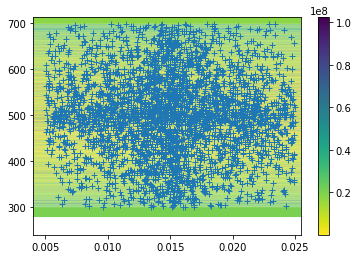

In [3]:
import pints.plot
fig, ax = pints.plot.surface(all_points, all_errors)
plt.show()

This looks awful!

To get a better plot, we rescale the parameter values so that they have a similar magnitude in both directions:

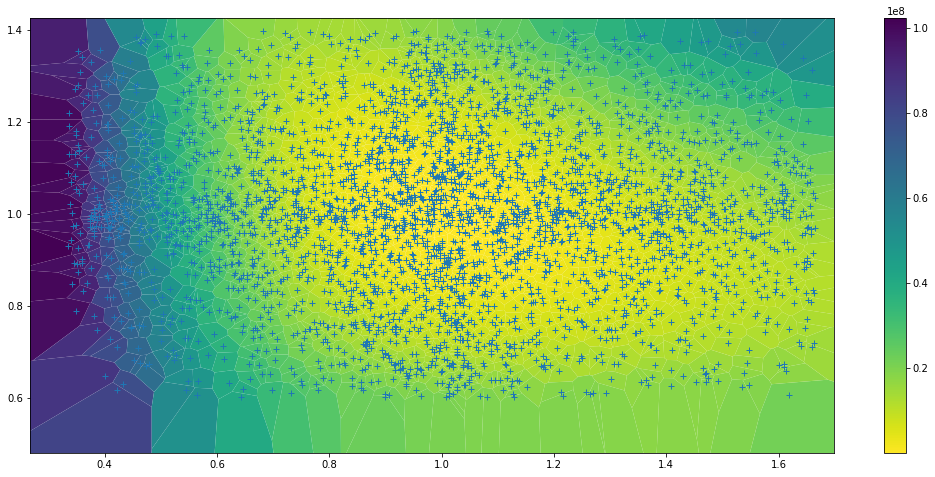

In [4]:
# Rescale the parameters to have similar magnitudes
plot_points = np.array(all_points)
plot_points[:, 0] /= 0.015
plot_points[:, 1] /= 500

fig, ax = pints.plot.surface(plot_points, all_errors, figsize=(18, 8))
plt.show()

In the above plot, each '+' indicates a point that the optimiser visited, while the region around each '+' is coloured according to the evaluated error measure.

This plot looks a lot better! In fact, it suggests that we should really have performed these parameter transformations in our model - so that the optimiser would have benefitted from them too.

Looking at the error bar we can see that some large errors cloud our vision of what's going on near the centre. We can try to reduce this effect using a log transform on the calculated errors.
We'll also disable the '+' markers, just to get a better look:

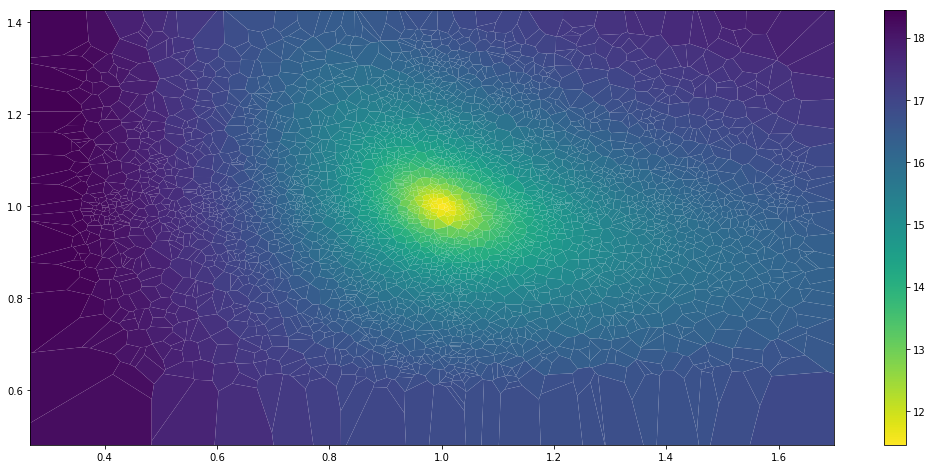

In [5]:
# Transform the errors
plot_errors = np.log(all_errors)

fig, ax = pints.plot.surface(plot_points, plot_errors, markers=None, figsize=(18, 8))
plt.show()

This can show us something about how the optimiser behaves.

It seems PSO has explored a lot, but searched points are clustered towards the center (where the true value lies), and also on the horizontal and vertical lines emanating from the true solution.

We can have a look at how it behaved near the optimum by defining some new boundaries, used only for plotting in the transformed space:

So we see PSO did a great job of exploring, and seems to have found a good minimum. But in this case it didn't spend much time exploring around that optimum.

We can compare this with CMAES:

In [6]:
# Create an optimiser
optimiser = pints.CMAES(x0, boundaries=boundaries)

# Run a number of iterations, storing all visited points and the corresponding evaluations
cmaes_points = []
cmaes_errors = []
for i in range(600):
    
    # Get some points to evaluate
    points = optimiser.ask()
    
    # Evaluate the error measure at these points
    errors = evaluator.evaluate(points)

    # Store the points and evaluations
    cmaes_points.extend(points)
    cmaes_errors.extend(errors)
    
    # Update the optimiser
    optimiser.tell(errors)

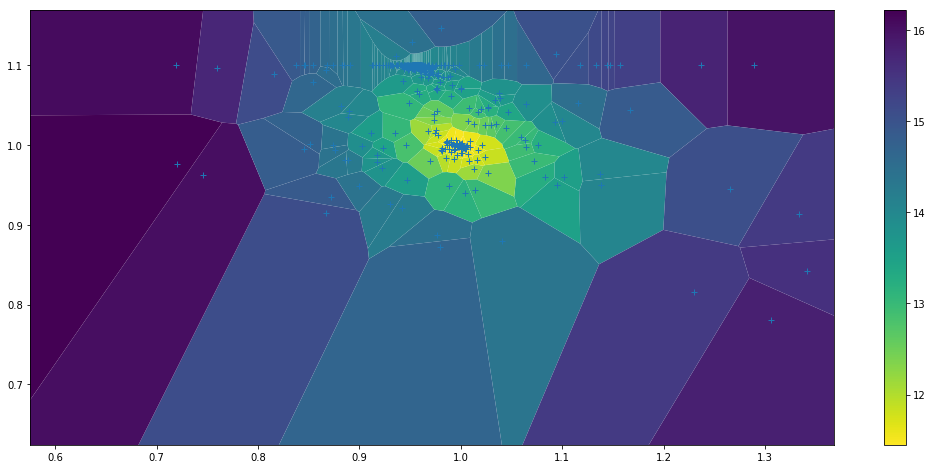

In [7]:
# Rescale the parameters to have similar magnitudes
plot_points = np.array(cmaes_points)
plot_points[:, 0] /= 0.015
plot_points[:, 1] /= 500

# Transform the errors
plot_errors = np.log(cmaes_errors)

# Plot the optimisation surface
fig, ax = pints.plot.surface(plot_points, plot_errors, figsize=(18, 8))
plt.show()

We can see here that CMAES spent hardly any time exploring the wider space.
Instead, it started with an exploration near the initial point (to the upper left of the optimum), and then quickly honed in on the correct solution.

We can adjust define some boundaries for plotting to see how it performed near the true solution:

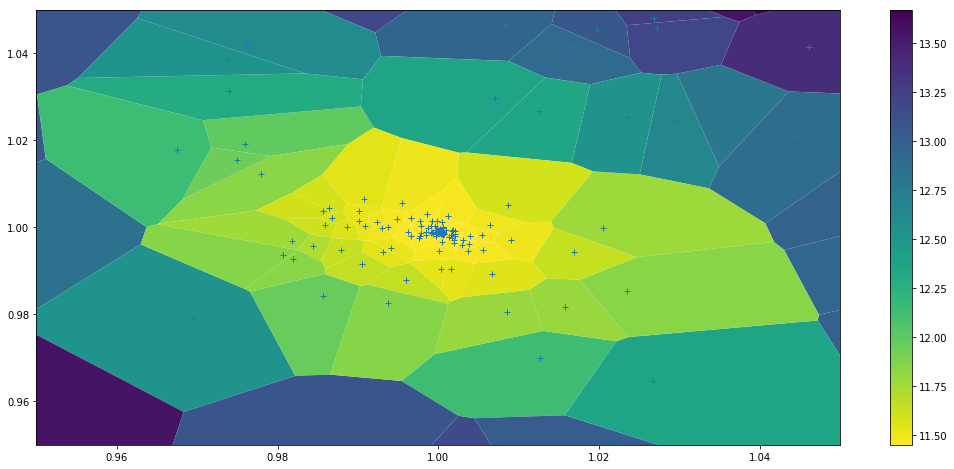

In [8]:
# Create some boundaries in the transformed parameter space, used only for plotting
plot_boundaries = pints.RectangularBoundaries([0.95, 0.95], [1.05, 1.05])

# Plot the optimisation surface
fig, ax = pints.plot.surface(plot_points, plot_errors, plot_boundaries, figsize=(18, 8))
plt.show()